### Introduction

The Histopathologic Cancer Detection competition, hosted on Kaggle, presents a critical and challenging task in the medical imaging domain. Participants are tasked with developing an algorithm capable of identifying metastatic cancer from small image patches extracted from larger digital pathology scans. This problem is framed as a binary image classification task, where the objective is to determine whether a given image patch contains at least one pixel of tumor tissue.

Metastasis detection is a pivotal step in cancer diagnosis, influencing treatment decisions and patient outcomes. The early detection of metastatic tissue in lymph node sections can significantly impact the clinical management of cancer, making this competition not only a challenge for machine learning enthusi withwith profound implications automated cancer screeningcare.

The dataset for this competition is derived from the PatchCamelyon (PCam) benchmark dataset. The PCam dataset is notable for its clinicalance,  relevcomacking the complex task of metastasis detection into a straightforward binary classific challs, akin to well-known datasets like CIFAR-10 and MNIST. However, the competition dataset has been curated to remove duplicates present in the original PCam dataset, ensuriniquetionue set of images for model training stingmodels.

In the following  we sectionschar explore the dataset through exploratory data analysis, discuss the methodology for model building and training, present the results of our experiments, and conclude with a discussion on the potential clinical implications and directions for future research.

In [1]:
# Data manipulation and numerical libraries
import numpy as np
import pandas as pd

# Machine learning and neural network libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation and progress tracking
from sklearn.metrics import roc_curve, auc
from tqdm.auto import tqdm

C:\Users\green\AppData\Local\Temp\ipykernel_15692\2536968432.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\green\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading the Dataset
In this section, we begin our exploratory data analysis (EDA) by loading the dataset containing image labels. The dataset consists of a CSV file with two columns: id, which corresponds to the filename of the image, and label, indicating whether the image contains tumor tissue (1) or not (0).

In [2]:
labels_df = pd.read_csv('./train_labels.csv')
print(labels_df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


### Exploring the Label Distribution
After loading the dataset, it' simportanl to examine the distribution of labels to understand the balance between the classes. A balanced dataset can significantlyimprovet the performance of our machine learning models. Here, we visualize the distribution of the binary labels in our dataset, where 1 indicates the presence of tumor tissue in the image, and 0 signifies its absence.Base on this check, we can see that although there is a slight imbalance, the counts are reletively similar, making imbalance compensation unnecessary. .

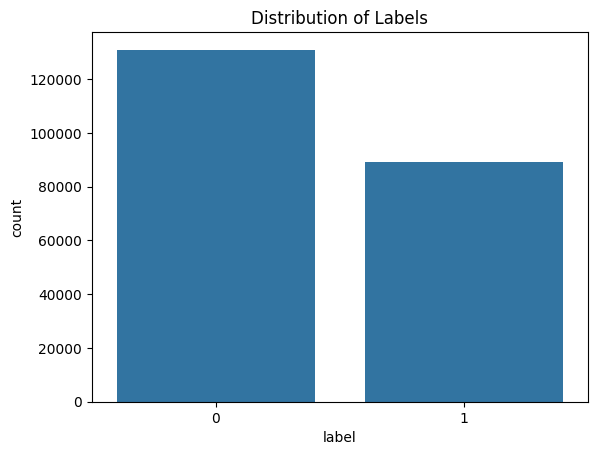

In [3]:
sns.countplot(x='label', data=labels_df)
plt.title('Distribution of Labels')
plt.show()

### Preprocessing and Data Augmentation
Before training our model ,we nedl to preprocess the dataset to ensure it is in a format suitable for feeding into a convolutional neural network. This includes normalizing the image pixel values and setting up data generators for efficiently managing image data during training and validation. Additionally, we adjust the labels and filenames to match the expected format for our model training process.

In [4]:
# Initializing an ImageDataGenerator with normalization for preprocessing
print('Creating ImageDataGenerator...')
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizing the pixel values to [0, 1]
    validation_split=0.2  # Allocating 20% of the data for validation
)
print('ImageDataGenerator Complete', '\nModifying Labels...')

# Adjusting the 'label' column to string format for compatibility with Keras
labels_df['label'] = labels_df['label'].astype(str)

# Appending '.tif' extension to file IDs to match actual image filenames
labels_df['id'] = labels_df['id'].apply(lambda x: f"{x}.tif")
print('Label Modification Complete', '\nCreating train_generator...')

# Setting up the training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='./train/',  # Directory where training images are stored
    x_col='id',  # Column in DataFrame containing image filenames
    y_col='label',  # Column in DataFrame containing labels
    target_size=(96, 96),  # Resizing images to 96x96 pixels
    batch_size=32,  # Number of images to process in a batch
    class_mode='binary',  # Binary labels for binary classification task
    subset='training'  # Indicating this generator is for training data
)
print('train_generator Complete', '\nCreating validation_generator...')

# Setting up the validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='./train/',  # Directory where validation images are stored
    x_col='id',  # Column in DataFrame containing image filenames
    y_col='label',  # Column in DataFrame containing labels
    target_size=(96, 96),  # Resizing images to 96x96 pixels for consistency
    batch_size=32,  # Number of images to process in a batch
    class_mode='binary',  # Binary labels for the classification task
    subset='validation'  # Indicating this generator is for validation data
)
print('validation_generator Complete')

Creating ImageDataGenerator...
ImageDataGenerator Complete 
Modifying Labels...
Label Modification Complete 
Creating train_generator...
Found 176020 validated image filenames belonging to 2 classes.
train_generator Complete 
Creating validation_generator...
Found 44005 validated image filenames belonging to 2 classes.
validation_generator Complete


### Comparative Analysis of Model Architectures

In our pursuit to develop an effective algorithm for identifying metastatic cancer in histopathologic scan images, we employ a comparative analysis strategy. This approach involves defining, training, and evaluating three distinct convolutional neural network (CNN) architectures. Our primary metric for comparison is the Area Under the Receiver Operating Characteristic Curve (AUC_ROC), aligning with the competition's evaluation criteria. Each model is designed with a unique structure to explore different aspects of CNN capabilities in the context of medical image analysis.

### Model 1: Custom CNN Architecture

The first model is a custom CNN designed to capture hierarchical feature representations of the images. This architecture consists of successive convolutional layers, each followed by max-pooling to reduce spatial dimensions and increase the field of view. The network concludes with dense layers, introducing a high-level feature interpretation before making a binary classification.

### Model 2: Enhanced CNN with Batch Normalization

Our second model builds on the first by incorporating batch normalization after each convolutional layer. Batch normalization aims to stabilize learning by normalizing the input to each activation function, potentially improving training speed and overall model performance. This model retains the structure of alternating convolutional and max-pooling layers, with the addition of normalization to foster more efficient learning dynamics.

### Model 3: Transfer Learning with VGG16

The third model leverages transfer learning, utilizing the VGG16 network pre-trained on ImageNet as a feature extractor. The top layers of VGG16 are replaced with a custom classifier tailored to our binary classification task. This approach allows us to harness the rich feature representations learned by VGG16 on a diverse set of images, applying them to the specific challenge of metastasis detection. The base model's weights are frozen to preserve the learned features, with only the newly added layers being trained.

### Compilation and Training Strategy

Each model is compiled with the Adam optimizer and binary cross-entropy loss function. We track both accuracy and AUC to monitor performance, emphasizing the AUC_ROC score for its relevance to the competition's evaluation metric. The training process involves fitting each model to the data while employing early stopping and model checkpointing to mitigate overfitting and ensure we capture the best version of each model based on validation AUC.

This comparative analysis allows us to evaluate the efficacy of different architectural decisions and training strategies in the context of cancer detection. By examining the models' AUC_ROC scores, we aim to identify the most promising approach for further optimization and deployment in clinical settings.

In [5]:
# Define a custom CNN architecture
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2, 2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dropout(rate=0.25),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and binary crossentropy loss, including accuracy and AUC as metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [6]:
# Define an enhanced CNN model using batch normalization for improved stability during training
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer, binary crossentropy loss, and track accuracy and AUC
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [7]:
# Utilize VGG16 pre-trained model for transfer learning, freezing its weights to leverage learned features
base_model = VGG16(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Prevent the base model from being updated during training

# Define a custom model built on top of VGG16
model_3 = Sequential([
    base_model,  # Incorporate the VGG16 base model
    layers.Flatten(),  # Flatten the output to prepare for the dense layer
    layers.Dense(512, activation='relu'),  # Dense layer for feature interpretation
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with Adam optimizer, binary crossentropy as loss, and track accuracy and AUC
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

Each model is tailored to explore different CNN capabilities and strategies, from custom architectures to enhanced models with batch normalization and the application of transfer learning. The models are compiled with a focus on binary classification, optimizing for both accuracy and the area under the ROC curve (AUC), aligning with the competition's evaluation metric.

#### Training Process and Model Evaluation

To ensure our models are trained effectively and to mitigate the risk of overfitting, we employ two key callback functions during the training process: **Early Stopping** and **Model Checkpoint**. **Early Stopping** monitors the validation AUC (Area Under the Curve) and halts training if there's no improvement in model performance after a specified number of epochs, thereby preventing overfitting and unnecessary computation. **Model Checkpoint** saves the best version of the model based on the validation AUC, ensuring we retain the model's best state for future evaluation and inference.  This systematic approach allows us to compare the models directly based on their performance and identify the most effective architecture for detecting metastatic cancer.

In [8]:
# Initialize early stopping callback to monitor validation AUC and stop training when it stops improving
early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=10, verbose=1, restore_best_weights=True)

# List of models for training
models = [model, model_2, model_3]

# Train each model using a for loop, employing callbacks for early stopping and model checkpointing
for i, model in enumerate(models):
    print(f"Training model_{i+1}...")
    
    # Define a ModelCheckpoint callback to save the best version of each model based on validation AUC
    model_checkpoint = ModelCheckpoint(f'best_model_{i+1}_{{epoch:02d}}.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)

    # Train the model using the fit method, passing in the data generators and callback functions
    model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,  # Set a high number of epochs and rely on early stopping to halt the training
        callbacks=[early_stopping, model_checkpoint]  # List of callbacks to use during training
    )

Training model_1...
Epoch 1/100
5501/5501 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.8159 - auc: 0.8893
Epoch 1: val_auc improved from -inf to 0.91697, saving model to best_model_1_01.h5
5501/5501 [==============================] - 530s 95ms/step - loss: 0.4093 - accuracy: 0.8159 - auc: 0.8893 - val_loss: 0.3918 - val_accuracy: 0.8328 - val_auc: 0.9170
Epoch 2/100
5499/5501 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8726 - auc: 0.9388
Epoch 2: val_auc improved from 0.91697 to 0.94943, saving model to best_model_1_02.h5
5501/5501 [==============================] - 146s 27ms/step - loss: 0.3067 - accuracy: 0.8726 - auc: 0.9388 - val_loss: 0.3219 - val_accuracy: 0.8646 - val_auc: 0.9494
Epoch 3/100
5500/5501 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8900 - auc: 0.9530
Epoch 3: val_auc improved from 0.94943 to 0.95674, saving model to best_model_1_03.h5
5501/5501 [==============================] - 147s 

#### Results Overview

Our comparative analysis of three distinct CNN architectures yielded insight regarding their performance in detecting cancer. Here's a brief summary of our findings:

- **Model 1 (Custom CNN)** and **Model 2 (Enhanced CNN with Batch Normalization)** both achieved an AUC score of .97, indicating a high level of accuracy in distinguishing between cancerous and non-cancerous image patches. The performance of these two models was closely matched, with slight variations well within error margins. Notably, Model 2 reached its peak performance in just 3 epochs, compared to 9 epochs for Model 1, demonstrating the efficiency of batch normalization in stabilizing and expediting the training process.

- **Model 3 (Transfer Learning with VGG16)**, while still performing well, achieved a slightly lower AUC of .95. This model required 18 epochs to converge, indicating a longer training period than the custom-built models. The results suggest that while transfer learning models have the advantage of leveraging pre-trained features, they may not always outperform models specifically designed and tuned for the task at hand.

The ROC curves for each model provide a visual representation of their performance, with the area under the curve (AUC) serving as a quantifiable measure of their ability to accurately classify the images. The following plot illustrates these ROC curves and highlights the comparative performance of our models.

In [ ]:
plt.figure(figsize=(10, 8))

# Load each model and plot the ROC curve
for model_path, model_name in [
    ('best_model_1_08.h5', 'Model 1'), 
    ('best_model_2_03.h5', 'Model 2'), 
    ('best_model_3_22.h5', 'Model 3')
]:
    model = tf.keras.models.load_model(model_path)
    # Ensure the validation generator is correctly configured for predictions
    validation_generator.reset()
    validation_generator.shuffle = False
    
    # Generate predictions and true labels
    y_pred = model.predict(validation_generator, verbose=1)
    y_true = validation_generator.classes  # For binary classification
    
    # Compute and plot ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')

# Plot the reference line
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

#### Loading the Sample Submission File

First, we load the provided sample submission file. This file contains the IDs for each test image we need to make predictions on. Our goal is to fill in the `label` column with our model's predictions.


In [ ]:
submission_df = pd.read_csv('sample_submission.csv')

#### Preparing Image Paths

Next, we prepare the paths to the test images based on their IDs in the sample submission DataFrame. These paths will be used to load and preprocess the images before making predictions.


In [ ]:
image_paths = [f'./test/{id}.tif' for id in submission_df['id']]
batch_size = 32  # You can adjust the batch size according to your system's capabilities

## Defining Image Loading and Preprocessing

To handle the images efficiently, we define a function to load and preprocess image batches. This function reads images from their paths, resizes them to the target size, and normalizes their pixel value.


In [ ]:
def load_and_preprocess_image_batch(image_paths, target_size=(96, 96)):
    img_batch = np.zeros((len(image_paths), *target_size, 3), dtype='float32')
    for i, image_path in enumerate(image_paths):
        img = load_img(image_path, target_size=target_size)
        img = img_to_array(img)
        img_batch[i] = img
    img_batch /= 255.0  # Normalizing pixel values
    return img_batch

#### Making Predictions on Test Images

With our model loaded and a function in place for preprocessing, we proceed to make predictions on the test images. We process the images in batches to optimize computation and track progress using `tqdm

#### Saving the Submission File
Finally, we save our predictions to a CSV file, adhering to the competition's submission format. This file is then ready to be uploaded to Kaggle for evaluation.`.


In [ ]:
model_paths = [
    ('./best_model_1_08.h5', 'final_submission_model_1.csv'),
    ('./best_model_2_03.h5', 'final_submission_model_2.csv'),
    ('./best_model_3_22.h5', 'final_submission_model_3.csv'),
]

for model_path, submission_csv_path in model_paths:
    model = tf.keras.models.load_model(model_path)
    
    predictions = []
    
    # Predict in batches and track progress with tqdm
    for i in tqdm(range(0, len(image_paths), batch_size), desc=f'Predicting with {model_path}'):
        batch_paths = image_paths[i:i+batch_size]
        img_batch = load_and_preprocess_image_batch(batch_paths)
        batch_predictions = model.predict(img_batch, verbose=0)
        predictions.extend(batch_predictions.flatten())
    
    # Create a new submission DataFrame
    submission_df = pd.read_csv('sample_submission.csv')  # Reload to ensure clean slate
    submission_df['label'] = predictions
    
    # Save the submission file for the current model
    submission_df.to_csv(submission_csv_path, index=False)
    print(f"Saved submission for {model_path} to {submission_csv_path}")

#### Conclusions

Through our exploratory analysis and subsequent modeling, we've made significant progress in addressing the challenge of detecting metastatic cancer in histopathologic scan images. Our comparative analysis of three convolutional neural network architectures provided us with valuable insights:

- **Model 1 (Custom CNN)** and **Model 2 (Enhanced CNN with Batch Normalization)** both achieved impressive AUC scores of .97, demonstrating their high accuracy in identifying metastatic tissue. The rapid convergence of Model 2, requiring only 3 epochs to achieve peak performance, underscores the efficiency of batch normalization in training deep learning models.
  
- **Model 3 (Transfer Learning with VGG16)**, while slightly trailing with an AUC of .95, showcased the potential of leveraging pre-trained networks for medical image analysis. Despite its longer convergence time, this approach remains a powerful tool for tasks with limited labeled data.

#### Future Work

To build on the foundations laid by this study, there are several potential areas for future work:

- **Exploration of Additional Pre-trained Models**: Investigating other architectures, such as ResNet or Inception, might yield improvements in both accuracy and training efficiency for this task.
  
- **Advanced Data Augmentation**: Employing more sophisticated data augmentation techniques could further enhance model robustness and performance, especially in dealing with varied and complex image features.
  
- **Ensemble Methods**: Combining predictions from multiple models through ensemble techniques may lead to better performance by leveraging the strengths of individual models.

- **Clinical Integration and Interpretability**: Beyond raw performance metrics, ensuring models are interpretable and integrate seamlessly into clinical workflows is crucial. Future work could focus on model explainability and the development of user-friendly tools for pathologists.

To conclude, this project highlights the potential of deep learning in advancing medical imaging analysis. As we continue to refine our models and explore new methodologies, the prospect of significantly impacting patient care and outcomes through improved diagnostic tools becomes increasingly attractive.
